# Recommending Amazon Products using Graph Neural Networks in PyTorch Geometric

- Read README.MD to install the dependencies.

Based on https://wandb.ai/manan-goel/gnn-recommender/reports/Recommending-Amazon-Products-using-Graph-Neural-Networks-in-PyTorch-Geometric--VmlldzozMTA3MzYw

In [1]:
from tqdm import tqdm
import numpy as np
from IPython.display import IFrame
import os

import torch
from torch import nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric import utils
from torch_geometric.transforms import RandomLinkSplit
import torch_geometric as pyg

from pyvis.network import Network

In [2]:
from model import GNN

In [3]:
from torch_geometric.explain import Explainer, PGExplainer

In [4]:
from torch_geometric.loader.node_loader import NodeLoader
from torch_geometric.loader.neighbor_loader import NeighborLoader
from torch_geometric.sampler.base import NodeSamplerInput
from torch_geometric.sampler.neighbor_sampler import NeighborSampler

# Data

In [5]:
# Save the splits and save as W&B artifacts
train_graph = torch.load('train.pt')
val_graph = torch.load('val.pt')
test_graph = torch.load('test.pt')

## Model

In [6]:
# This notebook uses the pre-trained model
# -> generated by `Recommending Amazon Products-Model.ipynb`

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim_wd = 0

#epochs = 300
epochs = 3

hidden_dim = 1024
dropout = 0.3
num_layers = 2
lr = 1e-5
node_emb_dim = 2  # 2 features: in/out-degrees
batch_size = 1024

In [8]:
model_name = "gnn.pt"

model = GNN(
    node_emb_dim, 
    hidden_dim, 
    hidden_dim, 
    num_layers, 
    dropout
).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate

# skip training if it is trained
model.load_state_dict(torch.load(model_name))
model.eval()

GNN(
  (convs): ModuleList(
    (0): SAGEConv(2, 1024, aggr=mean)
    (1): SAGEConv(1024, 1024, aggr=mean)
  )
  (post_mp): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
)

In [9]:
train_graph = train_graph.to(device)
val_graph = val_graph.to(device)

## Explain model using PGExplainer

In [10]:
# from torch_geometric.explain.config import ModelConfig

In [11]:
epochs_explainer = 5

In [12]:
pgexplainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=epochs_explainer, lr=0.003),
    explanation_type='phenomenon',  # only accepts phenomenon explanation
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',  # PGExplainer only accepts node or graph-level
        return_type='log_probs',
    ),
)

In [13]:
# need to train with batches, otherwise raises memory errors

train_dataloader = NeighborLoader(
    train_graph,
    num_neighbors=[50] * 2,
    batch_size=batch_size,
    input_nodes=[1 for _ in range(train_graph.x.shape[0])],
    shuffle=True,
)

In [14]:
sampled_data = next(iter(train_dataloader))

In [15]:
sampled_data

Data(x=[1043, 2], edge_index=[2, 4117], pos_edge_label=[49041], pos_edge_label_index=[2, 49041], neg_edge_label=[49041], neg_edge_label_index=[2, 49041], n_id=[1043], e_id=[4117], input_id=[1024], batch_size=1024)

In [16]:
target = torch.tensor([1 for _ in range(sampled_data.x.shape[0])])  # only positive examples (edge exists)

In [17]:
# if already trained just load

pgexplainer_fname = "pgexplainer.pt"
if os.path.exists(pgexplainer_fname):
    # load pre-trained model
    pgexplainer.algorithm.load_state_dict(torch.load("pgexplainer.pt"))
    # need to inform the algorithm that it is trained
    # pgexplainer.algorithm.epochs
    pgexplainer.algorithm._curr_epoch = epochs_explainer
    
else:
    # Train against a variety of node-level or graph-level predictions:
    for epoch in tqdm(range(epochs_explainer)):
        for data in train_dataloader:
            N = data.x.shape[0]
            target = torch.tensor([1 for _ in range(N)])  # only positive examples (edge exists)
            indices = np.random.choice(list(range(N)), replace=False, size=int(.1 * N))  # train only on 10%
            # do I need to guarantee that `node_index` is in indeces??

            for index in indices:  # Indices to train against.
                # check again this training. I suppose there is something wrong here - specially the indices
                loss = pgexplainer.algorithm.train(
                    epoch, 
                    model, 
                    torch.tensor(data.x).float().to(device), 
                    data.edge_index,
                    target=target, 
                    index=[index],
                )
                
    torch.save(pgexplainer.algorithm.state_dict(), "pgexplainer.pt")

### get the explanations

In [18]:
# Get the final explanations:
explanation_pge = pgexplainer(
    torch.tensor(train_graph.x).float().to(device), 
    train_graph.edge_index, 
    index=0,
    target=target[:train_graph.x.shape[0]]
)

In [19]:
print(explanation_pge.edge_mask)
print(explanation_pge.edge_mask.shape)
print(sum([1 for x in explanation_pge.edge_mask if x == 1]))

tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([98082])
44


In [20]:
explanation_pge.get_explanation_subgraph()

Explanation(edge_mask=[44], target=[1043], index=0, x=[262111, 2], edge_index=[2, 44])

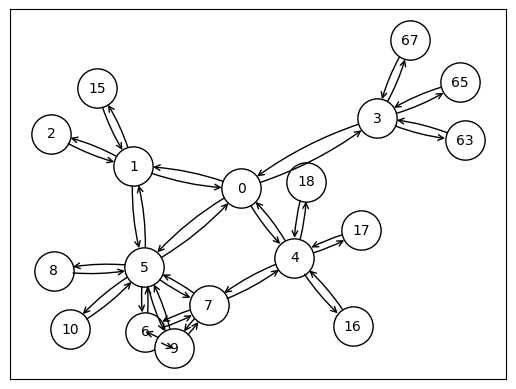

Subgraph visualization plot has been saved to 'None'


In [21]:
path_pge = None   # just show on cell
explanation_pge.visualize_graph()
print(f"Subgraph visualization plot has been saved to '{path_pge}'")

In [22]:
path_pge = 'pge-subgraph.pdf'
explanation_pge.visualize_graph(path_pge)

In [23]:
# IFrame(path_pge, width=800, height=500)

In [24]:
# explanation_pge.visualize_feature_importance() is not available for PGExplainer

In [25]:
# [x for x in dir(explanation_pge) if "__" not in x]

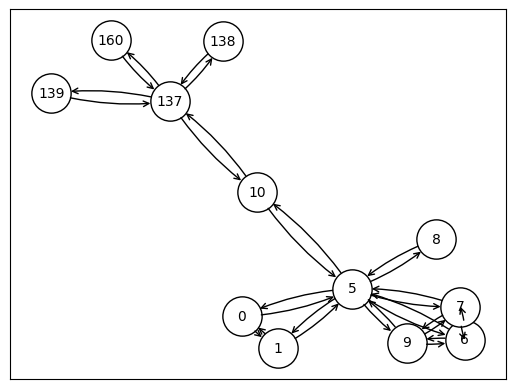

In [26]:
# Get the final explanations for index = 10
explanation_pge = pgexplainer(
    torch.tensor(train_graph.x).float().to(device), 
    train_graph.edge_index, 
    index=10,
    target=target[:train_graph.x.shape[0]]
)
explanation_pge.visualize_graph()

This is much faster that GNNExplainer

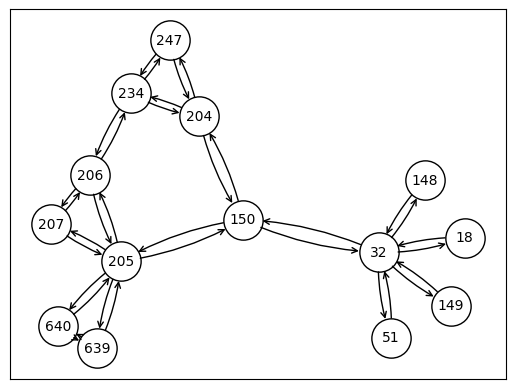

In [27]:
# Get the final explanations for index = 150
explanation_pge = pgexplainer(
    torch.tensor(train_graph.x).float().to(device), 
    train_graph.edge_index, 
    index=150,
    target=target[:train_graph.x.shape[0]]
)
explanation_pge.visualize_graph()

In [28]:
## How do I test using a motif (as shows in Table2 of PGExplainer)? Is it by using "edge mask"?